# Teaching a Quadricopter to Fly using RL Algorithims

#### DISCLAIMER
This is my submission for the final term project in Udacity's deep learning nanodegree. As such, most of the code from this project is curtosy Udacity. My contributions include:

- Desinging the reward function
- Tweaking network paramters (gamma, tau, number of hidden layers, nodes, batch normlization, dropout)
- All the content contained in this jupyter notebook (main algorithim, graphics, visuals, explanations)

Most of the code including the DDPG agent, actor, OUNoise, ReplayBuffer and critic were provided.

## Structure

- `Quadcopter_Project.ipynb` Main file
- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py` Agent that utilizes simple policy search
    - `DDPG.py`: Deep Determinist Policy Gradients Actor-Critic Agent
- `physics_sim.py`: This file contains the simulator for the quadcopter.

## The Task
The task is to get the quadcopter from point A to point B, where point A and B where each point only varied in one of the dimensions. In this case, I left the value for y and z the same for the initial position and the target position:

Starting Position: [0, 0, 10]

Target Position: [5, 0, 10]

#### Reward Function
Possibly the most important part of the reward function is to provide large feedback to the agent when a task is terminated. If it succeeds, give it a large reward, if it crashes, punish the agent. 

```python
# Punsished agent for terminating due to crashing on the ground
if (abs(np.sum(next_state[2::self.n_state_params] < 0.01))):
    done = True
    reward += -250
    print("CRASHED")
# Rewards agent for reaching the goal
elif (abs(next_state[0] - self.target_pos[0]) < 0.5 and
    abs(next_state[1] - self.target_pos[1]) < 1 and
    abs(next_state[2] - self.target_pos[2]) < 5):
    reward += 300
    done = True
    print("GOAL REACHED")
```
            
As for the non terminating rewards, I used 4 linear rewards. One for position relative to the target, one to minimize its speed, one to minimize angular velocity (keep it stable), and finally one to keep it above the ground. The last one I added because despite some success, the copter still tended to want to crash into the ground.

```python
pos = 0.25 * abs(np.sum(self.sim.pose[:3] - self.target_pos)) # rewards agent for being close to target
vel = 0.25 * abs(np.sum(self.sim.v)) # rewards agent for having a low velocity
angle = 0.05 * abs(np.sum(self.sim.angular_v)) # rewards agent for being stable
elevation = 0.125 * abs(self.sim.pose[3]) # rewards agent for staying away from the ground
```

## The Agent
A deep deterministic policy gradients agent. It utilizes an actor-critic method to train, Ornstein–Uhlenbeck noise to allow the agent to explore the state space, and a replay buffer to further optimize convergance.

#### RL Hyperparameters
```python
self.buffer_size = 100000
self.batch_size = 64
        
self.exploration_mu = 0.0
self.exploration_theta = 0.15
self.exploration_sigma = 0.2

self.gamma = 0.99  # discount factor
self.tau = 0.01 # for soft update of target parameters
```

#### Neural Netwrok Architecture and Hyperparamters
```python
# Actor
net = layers.Dense(units=256, activation='relu')(states)
net = layers.BatchNormalization()(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(units=128, activation='relu')(net)
net = layers.BatchNormalization()(net)
net = layers.Dropout(0.25)(net)
net = layers.Dense(units=128, activation='relu')(net)
net = layers.BatchNormalization()(net)
net = layers.Dropout(0.25)(net)

# Critic
# Add hidden layer(s) for state pathway
net_states = layers.Dense(units=128, activation='relu')(states)
net_states = layers.BatchNormalization()(net_states)
net_states = layers.Dropout(0.5)(net_states)
net_states = layers.Dense(units=256, activation='relu')(net_states)
net_states = layers.BatchNormalization()(net_states)
net_states = layers.Dropout(0.25)(net_states)

# Add hidden layer(s) for action pathway
net_actions = layers.Dense(units=128, activation='relu')(actions)
net_actions = layers.BatchNormalization()(net_actions)
net_actions = layers.Dropout(0.5)(net_actions)
net_actions = layers.Dense(units=256, activation='relu')(net_actions)
net_actions = layers.BatchNormalization()(net_actions)
net_actions = layers.Dropout(0.25)(net_actions)
```

## Main
Main algorithim that utilizes the agent and task.

In [6]:
import sys
import pandas as pd
import csv
import numpy as np

from task import Task
from agents.DDPG import DDPG

# Number of episodes to run algorithim
n_episodes = 500

# Initial Conditions and Target Position
initial_position = np.array([0., 0., 10., 0., 0., 0.])
initial_velocities = np.array([0., 0., 0.])
initial_angle_velocities = np.array([0., 0., 0.,])
target_position = np.array([5., 0., 10.])

runtime = 2

# Create the task
task = Task(init_pose = initial_position,
            init_velocities = initial_velocities,
            init_angle_velocities = initial_angle_velocities,
            target_pos = target_position,
            runtime = runtime)

# Create the agent
agent = DDPG(task) 

positions = []
steps = []
rewards = []
ave_rewards = [1]
best_path = []

best_reward = -float('inf')

recent_reward = np.zeros(10)
stop_reward_threshold = 150

# Training Algorithim
for i_episode in range(1, n_episodes+1):
    state = agent.reset_episode() # Restart agent for new episode
    count = 0
    
    if np.sum(recent_reward) / len(recent_reward) > stop_reward_threshold:
        print("\n\n\n\n\nCONGRATZ, YOURE AGENT WORKS, TRAINING STOPPED\n\n\n\n\n")
        break
    
    path = []
    
    # While episode is not over
    while True:
        action = agent.act(state) # get action from agent given the current environment state 
        next_state, reward, done = task.step(action) # apply the action and observe the next state and reward
        agent.step(action, reward, next_state, done) # have the agent update its behaviour
        state = next_state # update the current state with the next state
        
        count += 1
        
        path.append(next_state[0:3])
        
        # terminate the episode when a terminal state is returned
        if done:
            positions.append(next_state[0:3])
            steps.append(count)
            rewards.append(agent.total_reward)
            ave_rewards.append(((ave_rewards[-1] * (len(ave_rewards) - 1) + agent.total_reward)) / len(ave_rewards))
            
            recent_reward = np.concatenate(([agent.total_reward], recent_reward[0:-1]))
            
            if rewards[-1] > best_reward:
                best_path = path
                best_reward = rewards[-1]
            
            print("\r\nEpisode = {:4d}, steps = {:4.0f}, score = {:7.3f} (best = {:7.3f})".format(
                i_episode, count, rewards[-1], max(rewards)), end="\n\n")  # [debug]
            break
    sys.stdout.flush()

### DONE ###

### Example for output to csv ###
# file_output = 'data.txt'  
# labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
#           'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
#           'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
# results = {x : [] for x in labels}

# # Run the simulation, and save the results.
# with open(file_output, 'w') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(labels)
#     while True:
#         rotor_speeds = agent.act()
#         _, _, done = task.step(rotor_speeds)
#         to_write = [task.sim.time] + list(task.sim.pose) + \
#     list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
#         for ii in range(len(labels)):
#             results[labels[ii]].append(to_write[ii])
#         writer.writerow(to_write)
#         if done:
#             break

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

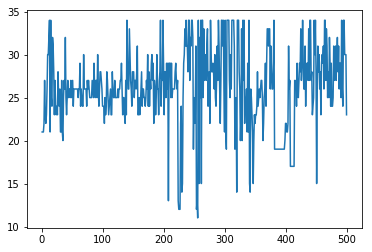

In [194]:
################################################
#### THE BELOW PLOTS IS NOT A REWARDS PLOT #####
################################################
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plots how long the drone lasted (number of time steps it was able to achieve) in each episode
plt.plot(np.arange(1, n_episodes + 1), steps)

Final Average Reward: -490.336224322


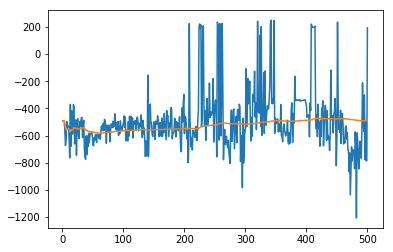

In [195]:
#### REWARDS PLOT ####

# Plots the rewards and average rewards over the episodes
plt.plot(np.arange(1, n_episodes + 1), rewards)
plt.plot(np.arange(1, n_episodes + 1), ave_rewards[1:])

print("Final Average Reward:", sum(rewards) / len(rewards))

In [196]:
# 3D Plot
def init_3D_plot():
    # Initializes the 3D Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # XYZ Scale
    ax.set_xlim3d(-5, 5)
    ax.set_ylim3d(-5, 5)
    ax.set_zlim3d(0, 20)

    # Plots the start position and the target position
    ax.scatter(initial_position[0], initial_position[1], initial_position[2], color = 'r', marker = "o")
    ax.scatter(target_position[0], target_position[1], target_position[2], color = 'g', marker = "^")
    
    return ax

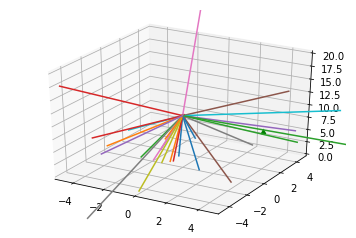

In [197]:
# Plots the displacement vector for every 5 episodes
ax = init_3D_plot()
x, y, z = zip(*positions[::20])
for i in range(0, len(x)):
    ax.plot([initial_position[0], x[i]], [initial_position[1], y[i]], zs=[initial_position[2], z[i]]) 
plt.show()

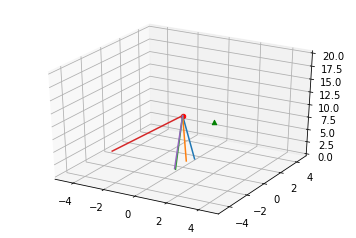

In [187]:
# Plot of the final positions of the last 5 runs
ax = init_3D_plot()
x, y, z = zip(*positions[-5:][:])
for i in range(0, len(x)):
    ax.plot([initial_position[0], x[i]], [initial_position[1], y[i]], zs=[initial_position[2], z[i]]) 
plt.show()

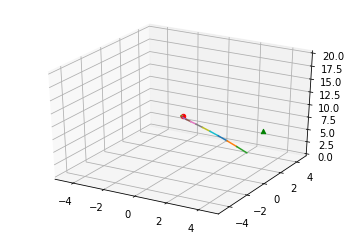

Final Position of best run: [ 4.51360634 -0.8406459   6.25987364]


In [198]:
# Plot of the best run
ax = init_3D_plot()
x, y, z = zip(*best_path)
for i in range(1, len(x)):
    ax.plot([x[i-1], x[i]], [y[i-1], y[i]], zs=[z[i-1], z[i]])
plt.show()
print("Final Position of best run:", best_path[-1])

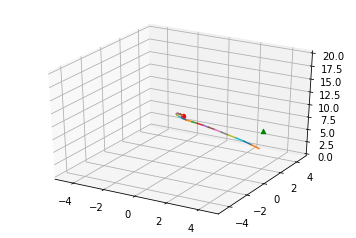

Final Position of last run: [ 4.82381973 -0.01821964  6.41281454]


In [199]:
# Plot of the last run
ax = init_3D_plot()
x, y, z = zip(*path)
for i in range(1, len(x)):
    ax.plot([x[i-1], x[i]], [y[i-1], y[i]], zs=[z[i-1], z[i]])
plt.show()
print("Final Position of last run:", path[-1])